In [1]:
import pandas as pd
import prototype as pt
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

c:\users\kobyl\anaconda3\envs\anomaly\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


[]


In [2]:
path_to_data = 'D:\\ubuntu\\zephyr_data\\'

In [3]:
import hashlib

def saveSnippetIntoFile(snippet):
    m = hashlib.sha256()
    m.update(snippet.encode('utf-8'))
    snippet_filename = m.hexdigest() + '.py'
    path_to_file = 'complex_exp_snippets_files\\' + snippet_filename
    
    with open(path_to_data + path_to_file, 'w', encoding='utf-8') as f:
        f.write(snippet)
        f.close()
    return path_to_file

# Вычисление A-индекса

Для случайной подвыборки кода длины 10000 вычислим А-индекс.

In [4]:
import pickle5 as pickle

pickle_file = open(path_to_data + 'complex_exp_code\\complex_exp_code.pickle','rb')
data = pickle.load(pickle_file)

In [5]:
data['path_to_file'] = data['snippet source code'].apply(saveSnippetIntoFile)

In [6]:
anomaly_results = pd.DataFrame.from_records([(item[3], item[0][22:], item[4])
                                            for item in pt.calc_anomalies(pt.get_python_paths(path_to_data + 'complex_exp_snippets_files\\'))], 
                                            columns =['a-index', 'path_to_file', 'message'])
df = data.join(anomaly_results.set_index('path_to_file'), on='path_to_file')

# Связь сложности выражений и А-индекса

Посмотрим на коррелированность числа операндов в выражениях и А-индекса.

In [10]:
df.loc[df['num_expr_terms'] > 0, ['num_expr_terms', 'a-index']].corr(method='spearman')

,num_expr_terms,a-index
num_expr_terms,1.000000,0.847267
a-index,0.847267,1.000000


In [12]:
import seaborn as sb
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='num_expr_terms', ylabel='a-index'>

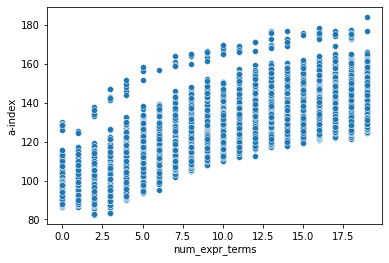

In [13]:
sb.scatterplot(x='num_expr_terms',
               y='a-index',
               data=df)

# Анализ связи А-индекса с частотой часто встречающихся токенов

In [14]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [15]:
from collections import Counter

df['max_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x.most_common(1)[0][1])
df['max_G_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x['Ġ'])

Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors


Подсчитаем корреляции частот часто встречающихся токенов с А-индексом.

In [16]:
df[['a-index', 'max_token_occurence', 'max_G_token_occurence']].corr(method='spearman')

,a-index,max_token_occurence,max_G_token_occurence
a-index,1.000000,-0.249148,-0.276987
max_token_occurence,-0.249148,1.000000,0.986562
max_G_token_occurence,-0.276987,0.986562,1.000000


Построим диаграмму рассеяния.

In [17]:
import seaborn as sb
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='max_G_token_occurence', ylabel='a-index'>

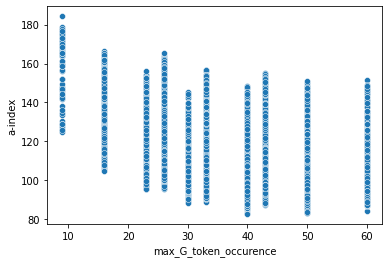

In [18]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df)

Уберем выбросы и снова построим

<AxesSubplot:xlabel='max_G_token_occurence', ylabel='a-index'>

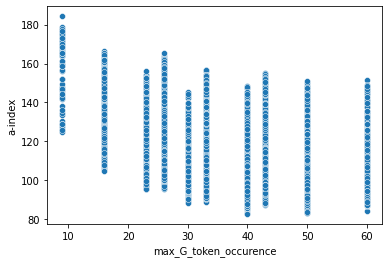

In [19]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_G_token_occurence'] <= df['max_G_token_occurence'].quantile(q=0.95)])

Подсчитаем корреляцию.

In [21]:
df.loc[(df['max_G_token_occurence'] <= df['max_G_token_occurence'].quantile(q=0.95)) &
       (df['max_G_token_occurence'] > 10), 
       ['max_G_token_occurence', 'a-index']].corr(method='spearman')

,max_G_token_occurence,a-index
max_G_token_occurence,1.000000,-0.258185
a-index,-0.258185,1.000000


# Анализ связи А-индекса с частотой подряд идущих токенов

Напишем функции для вычисления наибольших частот подряд идущих токенов.

In [22]:
from itertools import groupby

def computeMaxRepetitiveTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    return sorted(token_occurences, key=lambda x: x[1])[-1][1]

In [23]:
def computeMaxRepetitiveGTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    
    max_count = 0
    for token, count in sorted(token_occurences, key=lambda x: x[1]):
        if token == 'Ġ':
            max_count = max(max_count, count)    
    return max_count

Вычислим эти частоты.

In [24]:
df['max_consequtive_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveTokenSequenceLength)
df['max_consequtive_G_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveGTokenSequenceLength)

Подсчитаем корреляции.

In [25]:
df[['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,-0.151309,-0.151309
max_consequtive_token_occurence,-0.151309,1.000000,1.000000
max_consequtive_G_token_occurence,-0.151309,1.000000,1.000000


Посмотрим на графики

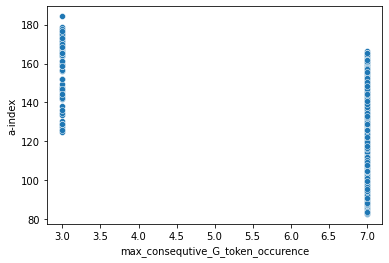

In [26]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df);

# Выводы

- частоты символа G слабо коррелированы с А-индексом;.

# Анализ связи А-индекса с некоторыми метриками кода

In [68]:
from radon.visitors import ComplexityVisitor
from radon.complexity import cc_rank
from radon.metrics import h_visit, mi_visit
from radon.raw import analyze
import numpy as np

Функции вычисления метрик

In [69]:
def computeCyclomaticComplexity(snippet):
    return ComplexityVisitor.from_code(snippet).functions_complexity

In [70]:
def computeHastadMetrics(snippet):
    hastad_metrics = h_visit(snippet).total
    return {metric:getattr(hastad_metrics, metric) for metric in dir(hastad_metrics) 
            if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}

In [71]:
def computeRawMetrics(snippet):
    try:
        raw_metrics = analyze(snippet)
        return {metric:getattr(raw_metrics, metric) for metric in dir(raw_metrics) 
                if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}
    except SyntaxError:
        return None

In [72]:
def computeMIindex(snippet):
    try:
        return mi_visit(snippet, multi=False)
    except SyntaxError:
        return np.nan

# Подсчет метрик

## Цикломатическая сложность

In [73]:
df['cc'] = df['snippet source code'].apply(computeCyclomaticComplexity)

## Метрики Хастада

In [74]:
hastad_metrics = df['snippet source code'].apply(computeHastadMetrics)

In [75]:
for col in hastad_metrics.loc[0].keys():
    df[col] = hastad_metrics.apply(lambda x: x[col])

## Сырые метрики

In [76]:
raw_metrics = df['snippet source code'].apply(computeRawMetrics)

In [77]:
for col in raw_metrics.loc[0].keys():
    df[col] = raw_metrics.apply(lambda x: x[col] if x else np.nan)

## Индекс качества кода

In [78]:
df['MI'] = df['snippet source code'].apply(computeMIindex)

# Связь с метриками

Формируем список всех метрик.

In [79]:
metric_names = ['cc', 'N1', 'N2', 'bugs', 'calculated_length', 'difficulty',
                'effort', 'h1', 'h2', 'length', 'time', 'vocabulary', 
                'volume', 'blank', 'comments', 'lloc', 'loc', 'multi',
                'single_comments', 'sloc', 'MI']

In [80]:
pd.set_option('display.max_columns', 500)

Подсчитаем корреляции

In [81]:
df[metric_names + ['a-index']].corr(method='spearman').round(2)

,cc,N1,N2,bugs,calculated_length,difficulty,effort,h1,h2,length,time,vocabulary,volume,blank,comments,lloc,loc,multi,single_comments,sloc,MI,a-index
cc,1.00,0.79,0.81,0.80,0.78,0.91,0.90,0.89,0.77,0.80,0.90,0.79,0.80,NaN,NaN,0.28,0.28,NaN,NaN,0.28,-0.83,0.22
N1,0.79,1.00,1.00,1.00,1.00,0.75,0.96,0.76,1.00,1.00,0.96,1.00,1.00,NaN,NaN,0.24,0.24,NaN,NaN,0.24,-0.92,0.70
N2,0.81,1.00,1.00,1.00,1.00,0.77,0.97,0.78,1.00,1.00,0.97,1.00,1.00,NaN,NaN,0.23,0.23,NaN,NaN,0.23,-0.92,0.69
bugs,0.80,1.00,1.00,1.00,1.00,0.76,0.97,0.77,1.00,1.00,0.97,1.00,1.00,NaN,NaN,0.23,0.23,NaN,NaN,0.23,-0.92,0.69
calculated_length,0.78,1.00,1.00,1.00,1.00,0.74,0.96,0.76,1.00,1.00,0.96,1.00,1.00,NaN,NaN,0.24,0.24,NaN,NaN,0.24,-0.92,0.70
difficulty,0.91,0.75,0.77,0.76,0.74,1.00,0.87,0.95,0.73,0.76,0.87,0.75,0.76,NaN,NaN,0.14,0.14,NaN,NaN,0.14,-0.77,0.28
effort,0.90,0.96,0.97,0.97,0.96,0.87,1.00,0.89,0.96,0.97,1.00,0.97,0.97,NaN,NaN,0.24,0.24,NaN,NaN,0.24,-0.93,0.56
h1,0.89,0.76,0.78,0.77,0.76,0.95,0.89,1.00,0.75,0.77,0.89,0.77,0.77,NaN,NaN,0.17,0.17,NaN,NaN,0.17,-0.78,0.30
h2,0.77,1.00,1.00,1.00,1.00,0.73,0.96,0.75,1.00,1.00,0.96,1.00,1.00,NaN,NaN,0.23,0.23,NaN,NaN,0.23,-0.92,0.71
length,0.80,1.00,1.00,1.00,1.00,0.76,0.97,0.77,1.00,1.00,0.97,1.00,1.00,NaN,NaN,0.23,0.23,NaN,NaN,0.23,-0.92,0.69


Вычислим медианные значения А-индекса при фиксированном значении метрик:

In [83]:
def groupedTargetMedian(data, 
                        feature_name, 
                        feature_value,
                        feature_std,
                        target_name):
    return data.loc[(data[feature_name] > feature_value - 0.1 * feature_std) &
                    (data[feature_name] < feature_value + 0.1 * feature_std), target_name].median(axis=0)

In [84]:
stds = df[metric_names].std(axis=0)

for metric_name in metric_names:
    df['a-index median given ' + metric_name + ' value'] = df[metric_name].apply(lambda x: 
                                                                                 groupedTargetMedian(df,
                                                                                                     metric_name,
                                                                                                     x,
                                                                                                     stds[metric_name],
                                                                                                     'a-index'))

Функция рисования графиков.

In [85]:
def plotScatterPlots(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.scatterplot(x=var_name, y='a-index', data=data)
            sb.scatterplot(x=var_name, y='a-index median given ' + var_name + ' value', data=data)
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

Показаны диаграммы рассеяния между А-индексом и метрикой, а также между медианой А-индекса и метрикой. Для более явной картины убрали выбросы.

In [86]:
df.loc[df['N1'] <= 100].shape[0] / df.shape[0] * 100

89.41

Показываются переменные 0 to 5 ...


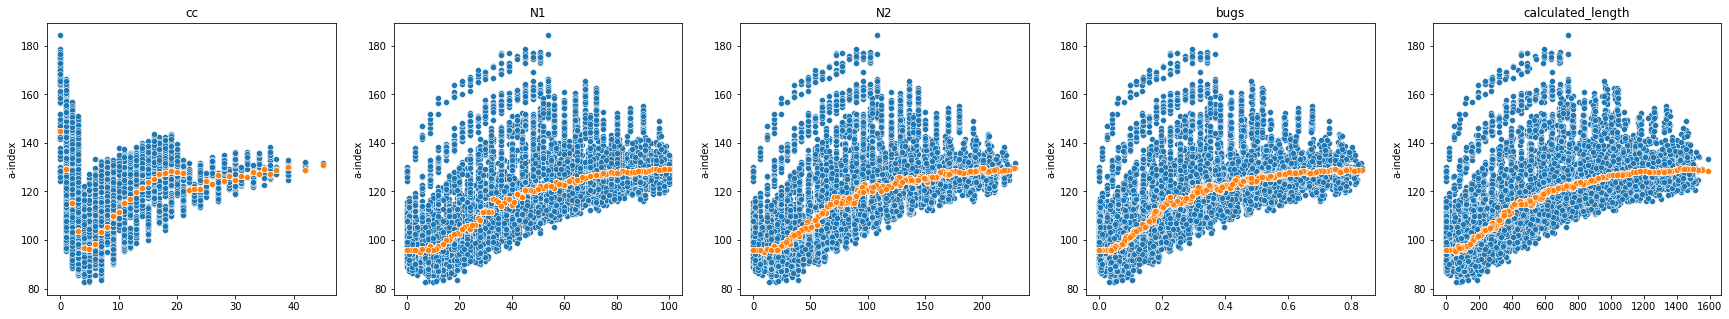

Показываются переменные 5 to 10 ...


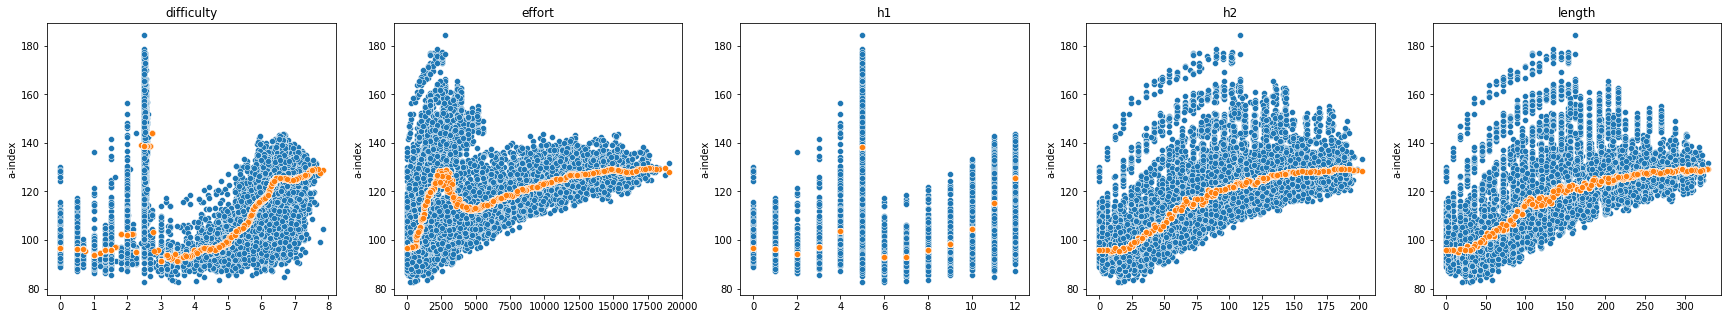

Показываются переменные 10 to 15 ...


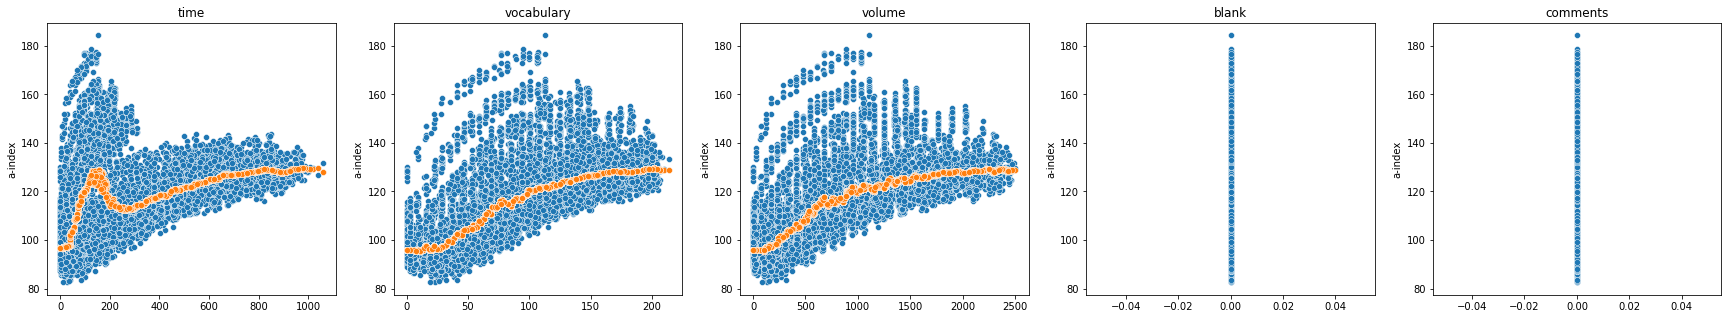

Показываются переменные 15 to 20 ...


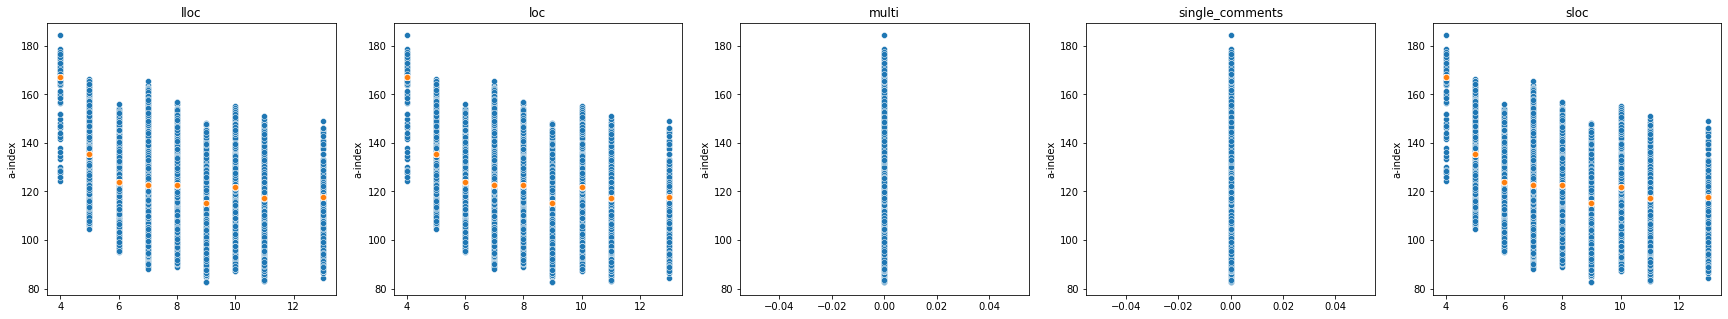

Показываются переменные 20 to 25 ...


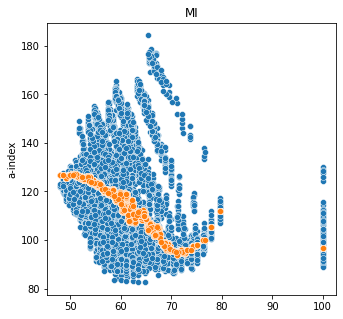

In [87]:
plotScatterPlots(df.loc[df['N1'] <= 100], metric_names)

In [88]:
def plotHistograms(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.histplot(x=var_name, data=data, bins=100,
                        stat='count')
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

Показываются переменные 0 to 5 ...


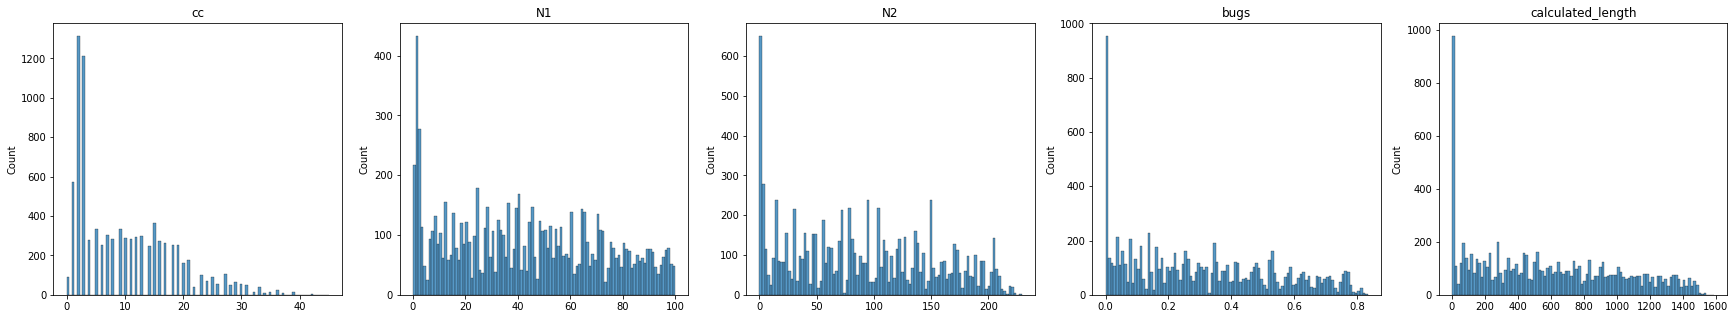

Показываются переменные 5 to 10 ...


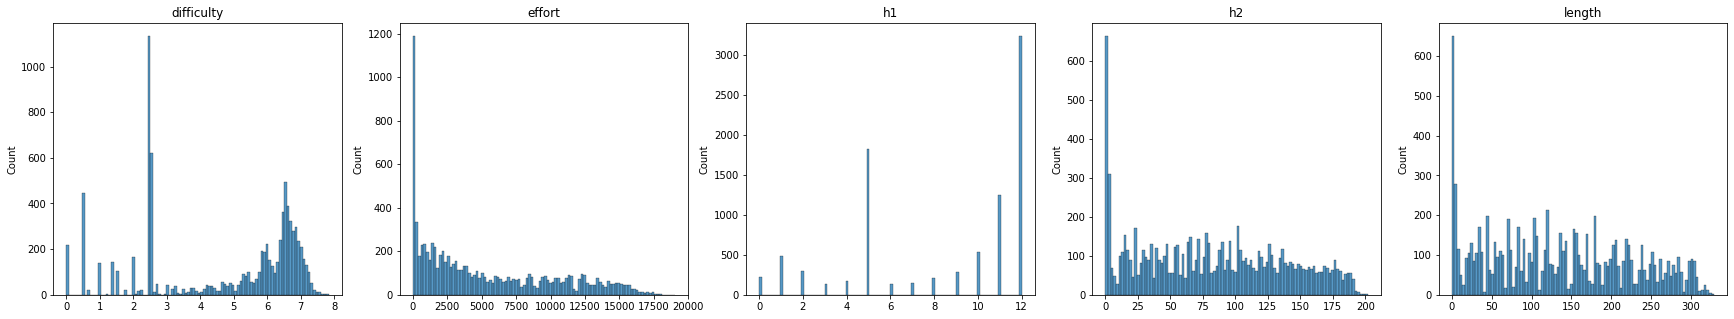

Показываются переменные 10 to 15 ...


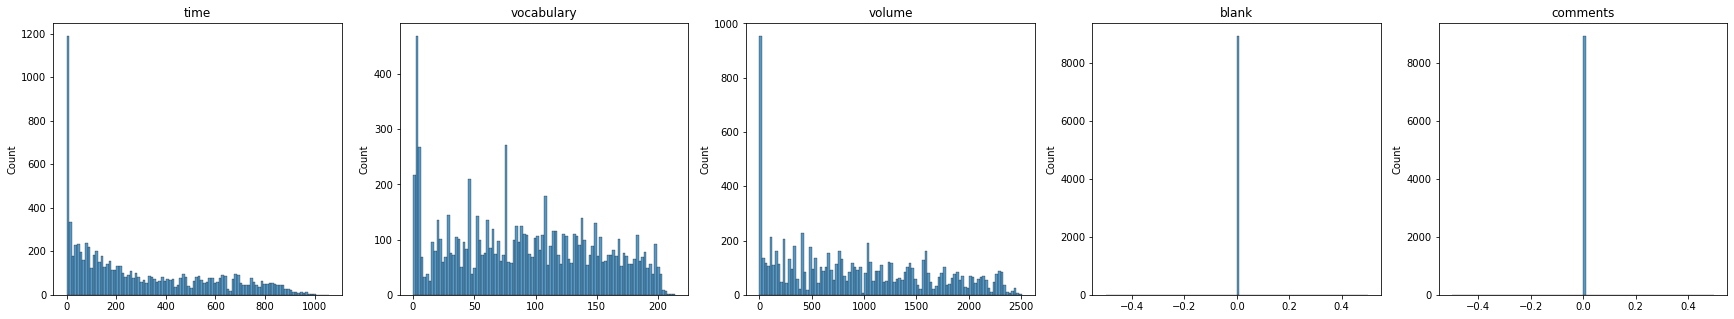

Показываются переменные 15 to 20 ...


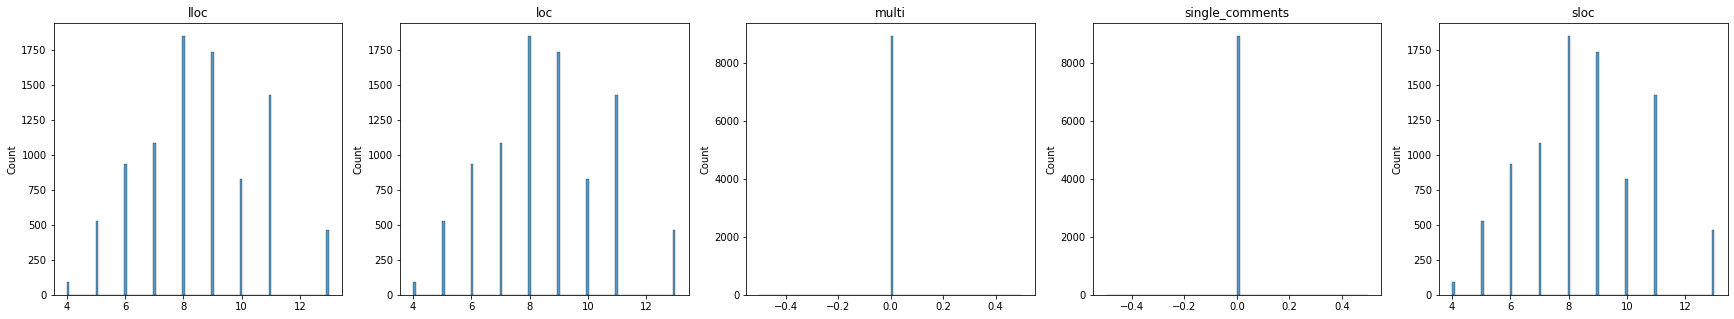

Показываются переменные 20 to 25 ...


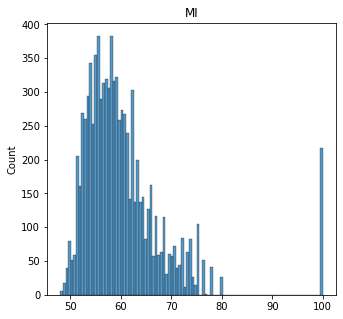

In [89]:
plotHistograms(df.loc[df['N1'] <= 100], metric_names);

# Выводы

- для малых значений метрик (кроме MI) А-индекс уменьшается с ростом значений метрик, а потом для достаточно больших значений он растет в ответ на увеличение значений метрик. Для некоторых метрик поведение немонотонное для больших значений метрик.

# Анализ распределения А-индекса

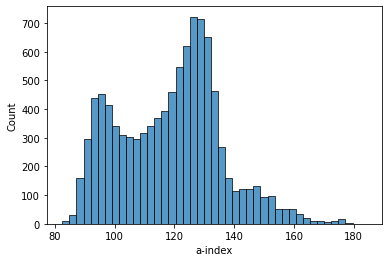

In [92]:
sb.histplot(x='a-index', data=df);

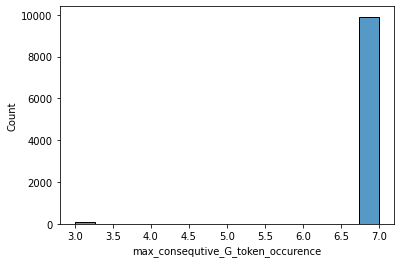

In [93]:
sb.histplot(x='max_consequtive_G_token_occurence', data=df);

# Анализ распределения А-индекса для короткого кода

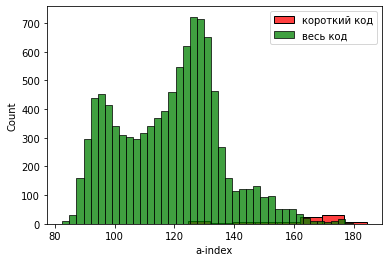

In [94]:
sb.histplot(x='a-index', data=df.loc[df['loc'] <=4], label='короткий код', color='r');
sb.histplot(x='a-index', data=df, label='весь код', color='g');
plt.legend();

Вмдно что короткий код имеет более высокий А-индекс.

<AxesSubplot:xlabel='num_expr_terms', ylabel='h2'>

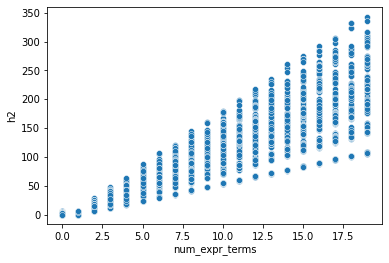

In [95]:
sb.scatterplot(x='num_expr_terms',
               y='h2',
               data=df)

Сложность выражения тесно связана с метрикой числа операндов.